# Analysis of AB testing result - The impact of the variation on revenue

## Introduction
This A/B test evaluates the impact of a new feature on user revenue. This test is implemented by randomly assigning users into two groups: Control (users who use the orginal design) and Test (users who use the new feature). If the new feature has an impact on user revenue, there will be a significant difference in the average revenue between the two groups.

## A/B Testing summary
#### 1. Test design
The original design and the new feature are randomly assigned to a sample of 19561 users. The observations only include users who completed purchase. Based on the given data, we have:
- 10041 users using original design 
- 9547 users using the new feature 

#### 2. Exploratory Data Analysis (EDA)
This part examines descriptive statistics of the dataset and suggests pre-process to satisfy conditions of A/B testing. These conditions are
- identical independent distribution: satisfied by the nature of sampling approach
- sufficient sample size: satisfied by the nature of test design
- normal distribution: checked by histogram and box-plot
- homogeneity of variance: checked by comparing standard deviation

The EDA shows that revenue data is highly right-skewed which deviates from the normal distribution. This implies that the data needs transforming in further analysis.

Furthermore, Control group has a higher variance than that of the Test group. This difference is caused by the existence of outliers in Control group.

#### 3. Statistical Analysis
Based on the EDA, the revenue data is log-transformed to address the right skewness. Then, a linear regression model is applied to formally test the difference in revenue between the two groups. The regression analysis is based on the log-transformed revenue, thus, the model coefficient will be interpreted as percentage of change in revenue.

## Result summary
The A/B testing result shows that the average revenue of the Test group is 0.71% higher than that of the Control group and this difference is statistically significant. This result confirms that implementation of the new feature might bring about an increase in revenue, however, the magnitude is relatively small in practical terms. 

It is noticeable that the model's R-squared is close to 0. This implies that the group assignment does not explain the variance in revenue. However, our main objective is to confirm the difference in revenue between two groups which is captured by the model coefficient and its p-value. Therefore, low value of R-squared is not the main concern of this analysis and can be addressed by including more variables.

This A/B Test can be further enhanced by incorporating more covariates/ confounding variables. In reality, the difference in revenue might be the result of other factors such as demographic or purchasing behaviours.

The A/B Testing process is detailed as followed.

### 1. Import data

In [1]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Import data
df = pd.read_csv('/Users/mellie/Desktop/173tech_DA_Test/exercise3_ab_test.csv')
df.head()

,user_id,Variant,Revenue
0,562625,Control,43.34
1,935989,Test,51.05
2,676822,Test,61.13
3,933683,Test,45.85
4,967127,Test,48.10


### 2. Exploratory Data Analysis
This analysis identifies the distribution of the revenue data and suggests the required pre-process to satisfy statistical assumption before A/B testing. 

The EDA result shows that revenue data is highly right-skewed with extreme outliers that would distort the A/B testing results. In order to offset this effect, revenue data will be log-transformed to close the distance of outliers and handle right-skewed data.

Figure 1 shows the statistic information of the two groups. The control groups has an extreme outlier of 951.0 as the highest revenue.
- 10014 users using the original design with an average revenue of 52.9
- 9547 users using the variation with an average revenue of 52.4
- The revenue data in Control group has a wider range (20.2 - 951.0) while revenue data in Test group is more centered (35.7 - 86.4)

In [2]:
# Get descriptive statistics for each group
ctrl_stats = df[df['Variant'] == 'Control']["Revenue"].describe().round(1)
test_stats = df[df['Variant'] == 'Test']["Revenue"].describe().round(1)

# Combine the statistics into a single DataFrame
stats_df = pd.DataFrame({
    'Control': ctrl_stats,
    'Test': test_stats
})

print("\nFigure 1: Descriptive statistics for Group Control and Test:")
print(stats_df)


Figure 1: Descriptive statistics for Group Control and Test:
       Control    Test
count  10014.0  9547.0
mean      52.9    52.4
std       22.5     6.9
min       20.2    35.7
25%       44.9    47.3
50%       50.3    51.4
75%       57.7    56.5
max      951.0    86.4


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


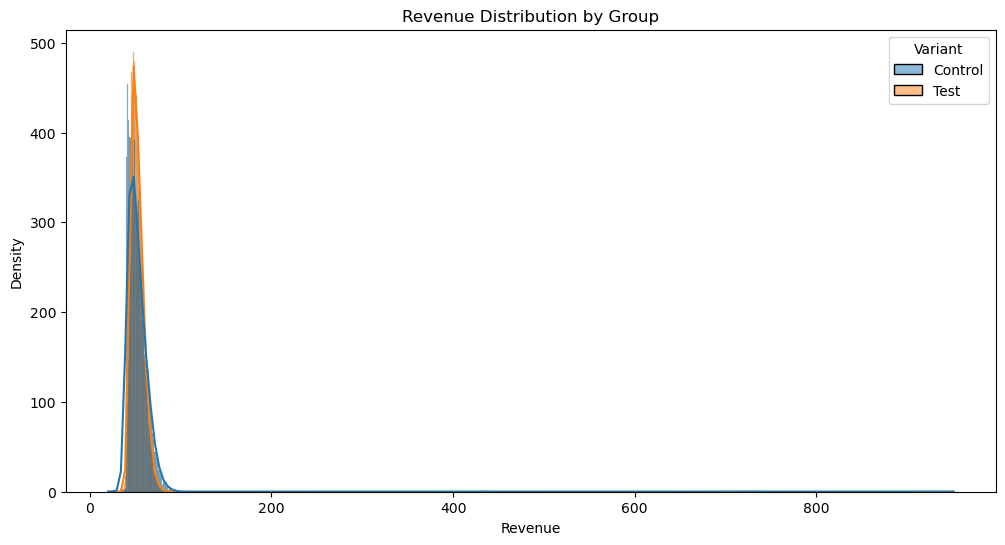

In [3]:
# Check distribution of revenue by group - highly skewed due to outliers
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Revenue', hue='Variant', kde=True)
plt.title('Revenue Distribution by Group')
plt.xlabel('Revenue')
plt.ylabel('Density')
plt.show()

Figure 2 shows the Boxplot of the two groups' revenue. In Control group, there are a few extremely high values, meanwhile, most values of Test group populates in the interquantile range. However, the removal of outliers might manipulate the completeness of A/B testing data. Therefore, it is recommended to transform the data instead of truncating.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


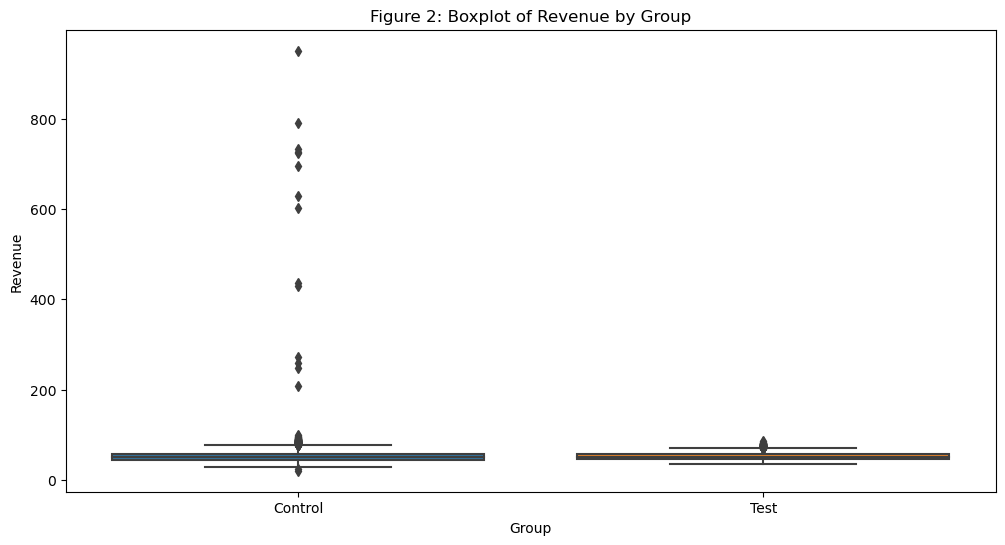

In [4]:
# Plot the boxplot of the revenue for both groups
plt.figure(figsize=(12, 6))
sns.boxplot(x='Variant', y='Revenue', data=df)
plt.title('Figure 2: Boxplot of Revenue by Group')
plt.xlabel('Group')
plt.ylabel('Revenue')
plt.show()

Figure 3 shows distribution of revenue data after log transformation. The data conforms to normality.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

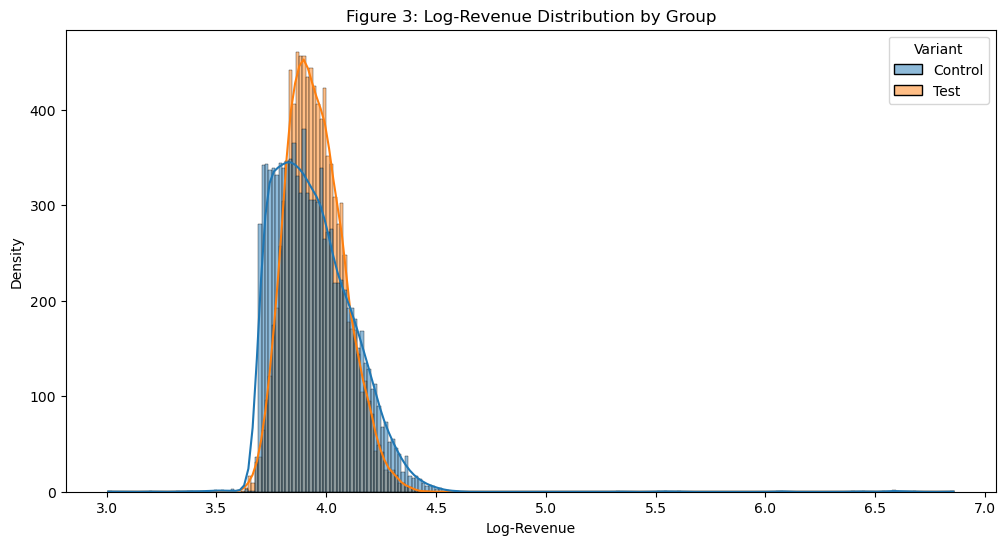

In [5]:
# Log-transform revenue data
df['log_revenue'] = np.log(df['Revenue'])

# Check distribution of log-revenue by group
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='log_revenue', hue='Variant', kde=True)
plt.title('Figure 3: Log-Revenue Distribution by Group')
plt.xlabel('Log-Revenue')
plt.ylabel('Density')
plt.show()

### 3. Linear Regression Model
The provided regression results analyses the effect of the new feature on the log-transformed revenue.

The coefficient of the parameter "group_dummy" is 0.007 with p-values of 0.002. Given the data is log-transformed, this implies that the users in the Test group produces 0.71% higher average revenue than that of Control group and this difference is statistically significant.

The R-squared and Adjusted R-squared are both close to 0, indicating that the only independent variable (group_dummy) has little explanatory power of the variance in log-revenue.
However, our main objective is to confirm the difference in revenue between two groups which is captured by the model coefficient and its p-value. Therefore, low value of R-squared is not the main concern of this analysis and can be addressed by including more variables.

In [6]:
# Create a dummy variable for the group
df['group_dummy'] = df['Variant'].apply(lambda x: 1 if x == 'Test' else 0)

# Fit the linear regression model on the log-transformed data
model = ols('log_revenue ~ C(group_dummy)', data=df).fit()

# Print the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     9.144
Date:                Mon, 27 May 2024   Prob (F-statistic):            0.00250
Time:                        01:04:11   Log-Likelihood:                 7785.8
No. Observations:               19561   AIC:                        -1.557e+04
Df Residuals:                   19559   BIC:                        -1.555e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               3.9437    

In [11]:
# Calculate the exponentiated coefficient
exp_coef = np.exp(model.params['C(group_dummy)[T.1]'])
print(f"The A/B testing result shows that the average revenue of the Test group is {exp_coef*100-100:.2f}% higher than that of the Control group and this difference is statistically significant.")

The A/B testing result shows that the average revenue of the Test group is 0.71% higher than that of the Control group and this difference is statistically significant.
